#  Project Title: Customer Segmentation and Sales Forecasting System for an Online Retailer

- https://archive.ics.uci.edu/dataset/352/online+retail

#### Dataset Information
- This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.





### Variables Table

| Variable Name | Role     | Type        | Description                                                               | Units    |
|---------------|----------|-------------|---------------------------------------------------------------------------|----------|
| InvoiceNo     | ID       | Categorical | A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'C', it indicates a cancellation |          |
| StockCode     | ID       | Categorical | A 5-digit integral number uniquely assigned to each distinct product      |          |
| Description   | Feature  | Categorical | Product name                                                              |          |
| Quantity      | Feature  | Integer     | The quantities of each product (item) per transaction                     |          |
| InvoiceDate   | Feature  | Date        | The day and time when each transaction was generated                      |          |
| UnitPrice     | Feature  | Continuous  | Product price per unit                                                    | Sterling |
| CustomerID    | Feature  | Categorical | A 5-digit integral number uniquely assigned to each customer              |          |
| Country       | Feature  | Categorical | The name of the country where each customer resides                       |          |


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing and inspecting the Data 

In [42]:
data = pd.read_excel('C:\\Users\\Abdellah1\\Desktop\\dataScience notebooks\\Online Retail\\Online Retail.xlsx')

In [43]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [44]:

print(F"The data shape is  {data.shape}")
print(F"-----------------------------------------")
print(F"{data.info()}")


The data shape is  (541909, 8)
-----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [45]:
#checking for duplicates
print(data.duplicated().sum())

5268


In [46]:
# checking for null values
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

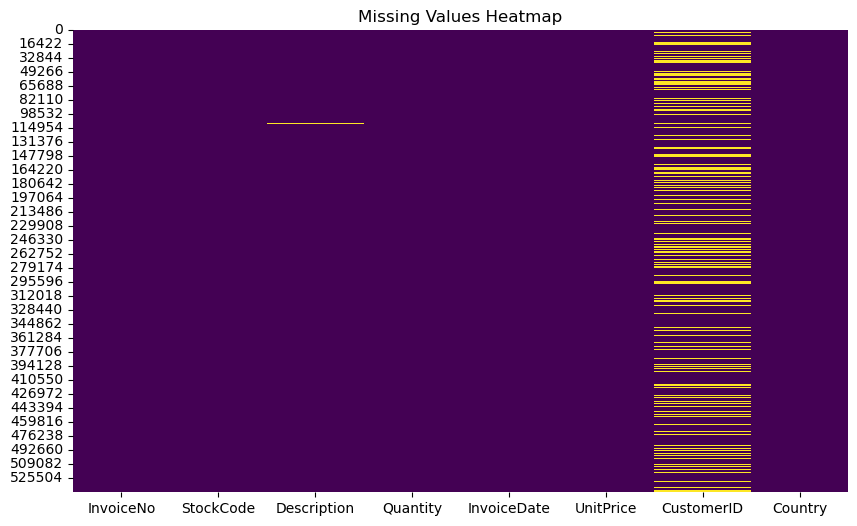

In [47]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

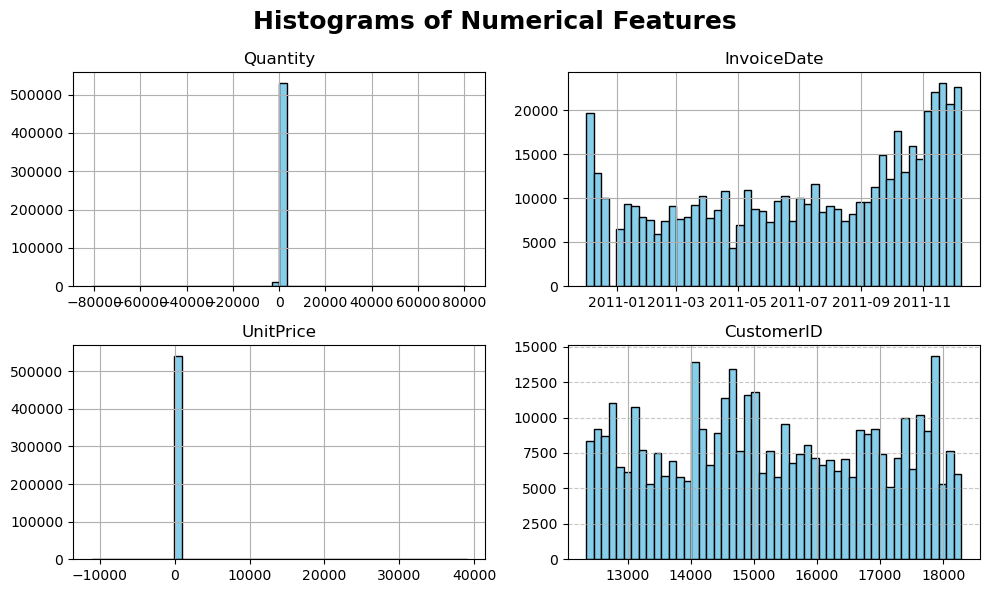

In [48]:
data.hist(
    bins=50, 
    figsize=(10, 6), 
    color='skyblue',  
    edgecolor='black'  
)

plt.suptitle('Histograms of Numerical Features', fontsize=18, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

- Quantity: Shows a highly skewed distribution with most values concentrated near zero, but there are extreme outliers on both the negative and positive sides.
- InvoiceDate: Displays the frequency of transactions over time, with a steady increase in transactions toward the end of the dataset's time range.
- UnitPrice: Similar to Quantity, it is highly skewed, with most values near zero and a few extreme outliers.
- CustomerID: Shows the distribution of customer IDs, with some IDs appearing more frequently than others.

## Data preprocessing

In [49]:
preProcessed_data = data.copy()

- remove duplicates and nulls

In [50]:
preProcessed_data.dropna(inplace=True)
preProcessed_data.drop_duplicates(inplace=True)

### Feature engneering

In [ ]:
preProcessed_data['TotalPrice'] = preProcessed_data['Quantity'] * preProcessed_data['UnitPrice']
preProcessed_data['TotalPrice'] = preProcessed_data['TotalPrice'].astype(float)

- splite date

In [53]:
preProcessed_data['Year'] = pd.to_datetime(preProcessed_data['InvoiceDate']).dt.year
preProcessed_data['Month'] = pd.to_datetime(preProcessed_data['InvoiceDate']).dt.month
preProcessed_data['Day'] = pd.to_datetime(preProcessed_data['InvoiceDate']).dt.day
preProcessed_data['Hour'] = pd.to_datetime(preProcessed_data['InvoiceDate']).dt.hour

### Outliers Handling

In [ ]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
